In [2]:
import os
os.environ['USE_PYGEOS'] = '0'
import json
import shapely
import geopandas as gpd
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

In [6]:
mapping = pd.read_csv("./data/2020_census_tract_to_nta.csv")
mapping.head()

,GEOID,CountyFIPS,BoroCode,BoroName,BoroCT2020,CT2020,CTLabel,NTACode,NTAType,NTAName,NTAAbbrev,CDTACode,CDTAType,CDTAName
0,36005001901,5,2,Bronx,2001901,1901,19.01,BX0101,0,Mott Haven-Port Morris,MttHvn,BX01,CD,BX01 Melrose-Mott Haven-Port Morris (CD 1 Appr...
1,36005001902,5,2,Bronx,2001902,1902,19.02,BX0101,0,Mott Haven-Port Morris,MttHvn,BX01,CD,BX01 Melrose-Mott Haven-Port Morris (CD 1 Appr...
2,36005001903,5,2,Bronx,2001903,1903,19.03,BX0101,0,Mott Haven-Port Morris,MttHvn,BX01,CD,BX01 Melrose-Mott Haven-Port Morris (CD 1 Appr...
3,36005002300,5,2,Bronx,2002300,2300,23.00,BX0101,0,Mott Haven-Port Morris,MttHvn,BX01,CD,BX01 Melrose-Mott Haven-Port Morris (CD 1 Appr...
4,36005002500,5,2,Bronx,2002500,2500,25.00,BX0101,0,Mott Haven-Port Morris,MttHvn,BX01,CD,BX01 Melrose-Mott Haven-Port Morris (CD 1 Appr...


In [5]:
neighborhoods = gpd.read_file('./data/2020_NTA.geojson')
neighborhoods.head()

,shape_area,ntaname,cdtaname,shape_leng,boroname,ntatype,nta2020,borocode,countyfips,ntaabbrev,cdta2020,geometry
0,35321206.58,Greenpoint,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28912.5661127,Brooklyn,0,BK0101,3,047,Grnpt,BK01,"MULTIPOLYGON (((-73.93213 40.72816, -73.93238 ..."
1,28854314.2319,Williamsburg,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28098.0270184,Brooklyn,0,BK0102,3,047,Wllmsbrg,BK01,"MULTIPOLYGON (((-73.96176 40.72523, -73.96154 ..."
2,15208960.6551,South Williamsburg,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),18250.2802623,Brooklyn,0,BK0103,3,047,SWllmsbrg,BK01,"MULTIPOLYGON (((-73.95024 40.70547, -73.94984 ..."
3,52266211.1496,East Williamsburg,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),43184.7728149,Brooklyn,0,BK0104,3,047,EWllmsbrg,BK01,"MULTIPOLYGON (((-73.92406 40.71411, -73.92404 ..."
4,9982321.61811,Brooklyn Heights,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,14312.5049112,Brooklyn,0,BK0201,3,047,BkHts,BK02,"MULTIPOLYGON (((-73.99236 40.68969, -73.99436 ..."


In [13]:
census = pd.read_csv("./data/2020_census_data.csv")
census.head()

,Geography,Geographic Area Name,Total
0,1400000US36005000100,Census Tract 1; Bronx County; New York,3772
1,1400000US36005000200,Census Tract 2; Bronx County; New York,4779
2,1400000US36005000400,Census Tract 4; Bronx County; New York,6272
3,1400000US36005001600,Census Tract 16; Bronx County; New York,5795
4,1400000US36005001901,Census Tract 19.01; Bronx County; New York,2292


In [28]:
census_lookup = {}
for name, population in zip(census["Geographic Area Name"], census["Total"]):
    parts = name.split("; ")
    assert len(parts) == 3
    boro = None
    if "Bronx" in parts[1]:
        boro = "Bronx" 
    elif "Richmond" in parts[1]:
        boro = "Staten Island"
    elif "Queens" in parts[1]:
        boro = "Queens"
    elif "New York" in parts[1]:
        boro = "Manhattan"
    elif "Kings" in parts[1]:
        boro = "Brooklyn"
    else:
        assert False
    tract = parts[0].replace("Census Tract ", "")
    if "." in tract:
        tract = tract.replace(".", "")
    else:
        tract = tract + "00"
    census_lookup[(boro, tract)] = population

In [31]:
def population_for_nta(code):
    filtered = mapping[mapping["NTACode"] == code]
    total = 0
    for boro, ct_code in zip(filtered["BoroName"], filtered["CT2020"]):
        total += census_lookup[boro, str(ct_code)]
    return total

neighborhoods["population"] = neighborhoods.apply(lambda row: population_for_nta(row["nta2020"]), axis=1)
neighborhoods.head()

,shape_area,ntaname,cdtaname,shape_leng,boroname,ntatype,nta2020,borocode,countyfips,ntaabbrev,cdta2020,geometry,population
0,35321206.58,Greenpoint,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28912.5661127,Brooklyn,0,BK0101,3,047,Grnpt,BK01,"MULTIPOLYGON (((-73.93213 40.72816, -73.93238 ...",38980
1,28854314.2319,Williamsburg,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28098.0270184,Brooklyn,0,BK0102,3,047,Wllmsbrg,BK01,"MULTIPOLYGON (((-73.96176 40.72523, -73.96154 ...",64444
2,15208960.6551,South Williamsburg,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),18250.2802623,Brooklyn,0,BK0103,3,047,SWllmsbrg,BK01,"MULTIPOLYGON (((-73.95024 40.70547, -73.94984 ...",47703
3,52266211.1496,East Williamsburg,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),43184.7728149,Brooklyn,0,BK0104,3,047,EWllmsbrg,BK01,"MULTIPOLYGON (((-73.92406 40.71411, -73.92404 ...",52998
4,9982321.61811,Brooklyn Heights,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,14312.5049112,Brooklyn,0,BK0201,3,047,BkHts,BK02,"MULTIPOLYGON (((-73.99236 40.68969, -73.99436 ...",25092


In [33]:
volunteer_locations = []
with open("./data/adopt_your_spot_geocoded.json", "r") as f:
    raw_data = json.load(f)
    for v in raw_data:
        coord = v["location"]["geometry"]["location"]
        volunteer_locations.append(coord)

In [37]:
def volunteers_in_neighborhood(neighborhood):
    def volunteer_in_neighborhood(volunteer):
        return neighborhood['geometry'].contains(shapely.Point(volunteer['lng'], volunteer['lat']))
    return [v for v in volunteer_locations if volunteer_in_neighborhood(v)]

def num_volunteers_in_neighborhood(neighborhood):
    n_volunteers = len(volunteers_in_neighborhood(neighborhood))
    return n_volunteers if n_volunteers > 0 else None

In [64]:
def volunteers_per_capita(x):
    # per 10k
    if x['num_volunteers'] is None or x['num_volunteers'] <= 0:
        return None
    if x['population'] == 0:
        return x['num_volunteers']
    return x['num_volunteers'] * 10000 / x['population']

def volunteers_per_km2(x):
    # assuming the internal units are approximately m2
    if x['num_volunteers'] is None or x['num_volunteers'] <= 0:
        return None
    return x['num_volunteers'] * 1000000 / float(x['shape_area'])

neighborhoods['num_volunteers'] = neighborhoods.apply(num_volunteers_in_neighborhood, axis=1)
neighborhoods['num_volunteers_per_capita'] = neighborhoods.apply(volunteers_per_capita, axis=1)
neighborhoods['num_volunteers_per_km2'] = neighborhoods.apply(volunteers_per_km2, axis=1)
neighborhoods.head()

,shape_area,ntaname,cdtaname,shape_leng,boroname,ntatype,nta2020,borocode,countyfips,ntaabbrev,cdta2020,geometry,population,num_volunteers,num_volunteers_per_capita,num_volunteers_per_km2
0,35321206.58,Greenpoint,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28912.5661127,Brooklyn,0,BK0101,3,047,Grnpt,BK01,"MULTIPOLYGON (((-73.93213 40.72816, -73.93238 ...",38980,15.0,3.848127,0.424674
1,28854314.2319,Williamsburg,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28098.0270184,Brooklyn,0,BK0102,3,047,Wllmsbrg,BK01,"MULTIPOLYGON (((-73.96176 40.72523, -73.96154 ...",64444,11.0,1.706908,0.381225
2,15208960.6551,South Williamsburg,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),18250.2802623,Brooklyn,0,BK0103,3,047,SWllmsbrg,BK01,"MULTIPOLYGON (((-73.95024 40.70547, -73.94984 ...",47703,NaN,NaN,NaN
3,52266211.1496,East Williamsburg,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),43184.7728149,Brooklyn,0,BK0104,3,047,EWllmsbrg,BK01,"MULTIPOLYGON (((-73.92406 40.71411, -73.92404 ...",52998,8.0,1.509491,0.153063
4,9982321.61811,Brooklyn Heights,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,14312.5049112,Brooklyn,0,BK0201,3,047,BkHts,BK02,"MULTIPOLYGON (((-73.99236 40.68969, -73.99436 ...",25092,3.0,1.195600,0.300531


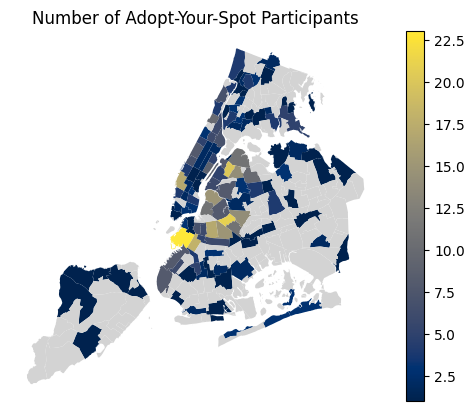

In [66]:
neighborhoods.plot(column='num_volunteers',
                   cmap='cividis',
                   legend=True,
                   missing_kwds={'color': 'lightgrey'})
plt.title('Number of Adopt-Your-Spot Participants')
plt.axis('off')
plt.show()

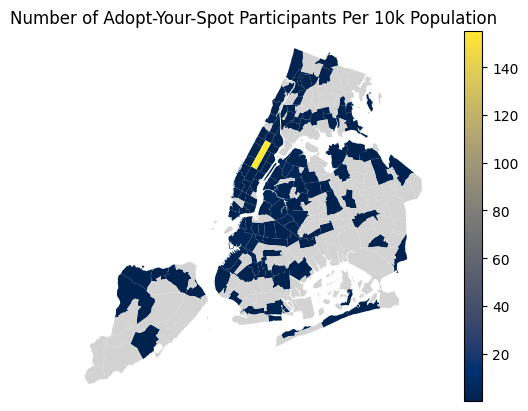

In [68]:
neighborhoods.plot(column='num_volunteers_per_capita',
                   cmap='cividis',
                   legend=True,
                   missing_kwds={'color': 'lightgrey'})
plt.title('Number of Adopt-Your-Spot Participants Per 10k Population')
plt.axis('off')
plt.show()

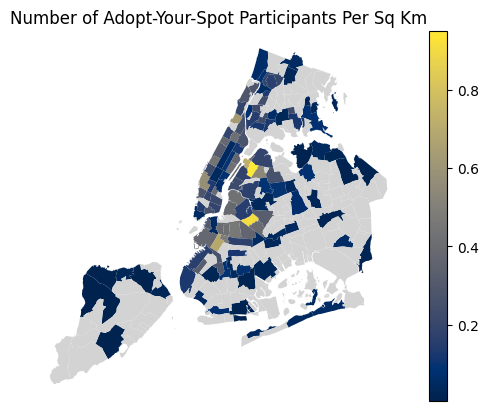

In [69]:
neighborhoods.plot(column='num_volunteers_per_km2',
                   cmap='cividis',
                   legend=True,
                   missing_kwds={'color': 'lightgrey'})
plt.title('Number of Adopt-Your-Spot Participants Per Sq Km')
plt.axis('off')
plt.show()

In [60]:
filtered_neighborhoods = neighborhoods[neighborhoods['num_volunteers'] > 0]
len(neighborhoods), len(filtered_neighborhoods)

(262, 119)

In [70]:
json_data = []
for _, n in neighborhoods.iterrows():
    json_data.append({
        "name": n['ntaname'],
        "count": n['num_volunteers'],
        "per_capita": n['num_volunteers_per_capita'],
        "per_km2": n['num_volunteers_per_km2']
    })
import json
with open("./data/processed_data.json", "w") as f:
    json.dump(json_data, f, indent=2)